# Análise dos datasets

Foram utilizados dois datasets para os experimentos: um mais simples com 2 dimensões que foi disponibilizado pela professora, e outro um pouco mais complexo envolvendo um problema real de N dimensões.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random
from scipy.spatial import distance as dist
from tqdm import tqdm 

## Dataset 2D

O dataset de 2 dimensões tem como features as coordenadas [x, y] sobre a localização dos pontos no espaço.

In [2]:
data_1 = [i.strip().split() for i in open("./cluster.dat").readlines()]
data_1 = pd.DataFrame(data_1)
data_1[0] = pd.to_numeric(data_1[0])
data_1[1] = pd.to_numeric(data_1[1])

In [3]:
print('Tamanho do dataset: {}'.format(data_1.shape))

Tamanho do dataset: (573, 2)


In [4]:
data_1.head()

,0,1
0,1555.0,28.65
1,1490.0,27.55
2,1445.0,28.35
3,1415.0,28.80
4,1375.0,28.05


In [5]:
data_1 = data_1.rename({0: 'x', 1: 'y'}, axis=1) 

Verificando se há valores nulos:

In [6]:
data_1.isna().sum()

x    0
y    0
dtype: int64

Podemos observar que não há outliers pois os números de 90% e 95% são bem próximos.

In [7]:
data_1.describe([0.1, 0.9, 0.95])

,x,y
count,573.000000,573.000000
mean,1849.808028,15.227836
std,900.129972,8.292268
min,335.000000,1.950000
10%,789.000000,4.550000
50%,1655.000000,17.200000
90%,3299.000000,26.000000
95%,3427.000000,27.250000
max,3635.000000,29.150000


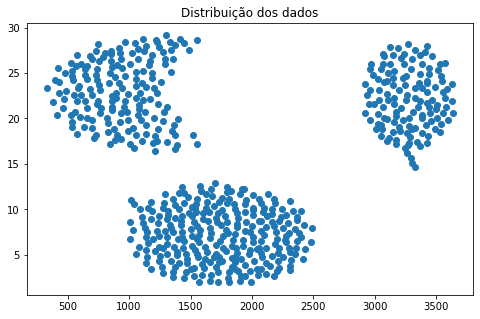

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(data_1['x'], data_1['y'])
plt.title('Distribuição dos dados')
plt.show()

## U.S. News and World Report’s College Data

Esse dataset é formado por estatísticas de um grande número de faculdades dos EUA, da edição de 1995 do "US News and World Report". Este conjunto de dados foi retirado da biblioteca StatLib, que é mantida na Carnegie Mellon University e foi disponibilizado pela plataforma Kaggle. (https://www.kaggle.com/flyingwombat/us-news-and-world-reports-college-data).

O problema busca identificar se as faculdades são públicas ou privadas através das features.

In [9]:
data_2 = pd.read_csv('College.csv')

In [10]:
print('Tamanho do dataset: {}'.format(data_2.shape))

Tamanho do dataset: (777, 19)


In [11]:
data_2.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


Significado de cada feature:

    - Private: Não e Sim indicando universidade pública ou privada;
    - Apps: Número de aplicações recebidas;
    - Accept: Número de aplicações aceitas;
    - Enroll: Número de novos alunos matriculados;
    - Top10perc: Percentil dos novos alunos - 10% melhores do H.S. aula;
    - Top25perc: Percentil dos novos alunos - 25% melhores do H.S. aula;
    - F.Undergrad: Número de alunos de graduação em tempo integral; 
    - P.Undergrad: Número de alunos de graduação em meio período;
    - Outstate: Taxas externas do estado; 
    - Room.Board: Moradia e custos de alimentação;
    - Books: Custo estimado de livros; 
    - Personal: Custo pessoal estimado; 
    - PhD: Percentual do corpo docente com Ph.D.;
    - Terminal: Percentual do corpo docente com grau terminal; 
    - S.F.Ratio: Razão aluno/professor; 
    - perc.alumni: Percentual de ex-alunos que doam; 
    - Expend: Gastos com instrução por aluno;        
    - Grad.Rate: Taxa de graduação.
    
O private é o label do dataset portanto para não haver vazamento de dados, vamos retirá-lo do dataset, de mesma forma do 'Unnamed: 0' que se trata de qual faculdade estamos tratando.

Tipo de dados de cada feature:

In [12]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   777 non-null    object 
 1   Private      777 non-null    object 
 2   Apps         777 non-null    int64  
 3   Accept       777 non-null    int64  
 4   Enroll       777 non-null    int64  
 5   Top10perc    777 non-null    int64  
 6   Top25perc    777 non-null    int64  
 7   F.Undergrad  777 non-null    int64  
 8   P.Undergrad  777 non-null    int64  
 9   Outstate     777 non-null    int64  
 10  Room.Board   777 non-null    int64  
 11  Books        777 non-null    int64  
 12  Personal     777 non-null    int64  
 13  PhD          777 non-null    int64  
 14  Terminal     777 non-null    int64  
 15  S.F.Ratio    777 non-null    float64
 16  perc.alumni  777 non-null    int64  
 17  Expend       777 non-null    int64  
 18  Grad.Rate    777 non-null    int64  
dtypes: float

Verificando se há valores nulos:

Pela verificação de outliers utilizando os quartis, retiramos as amostras que são maiores do que 90%

In [13]:
for i in data_2:
    print(data_2[i].describe([0.1, 0.9, 0.95]), '\n')

count                                   777
unique                                  777
top       University of Southern California
freq                                      1
Name: Unnamed: 0, dtype: object 

count     777
unique      2
top       Yes
freq      565
Name: Private, dtype: object 

count      777.000000
mean      3001.638353
std       3870.201484
min         81.000000
10%        457.600000
50%       1558.000000
90%       7675.000000
95%      11066.200000
max      48094.000000
Name: Apps, dtype: float64 

count      777.000000
mean      2018.804376
std       2451.113971
min         72.000000
10%        361.600000
50%       1110.000000
90%       4814.200000
95%       6979.200000
max      26330.000000
Name: Accept, dtype: float64 

count     777.000000
mean      779.972973
std       929.176190
min        35.000000
10%       154.000000
50%       434.000000
90%      1903.600000
95%      2757.000000
max      6392.000000
Name: Enroll, dtype: float64 

count    777.000000
mean   

In [14]:
data_2 = data_2[(data_2['Apps'] < 2200) | (data_2['Accept'] <  4814 ) | (data_2['Enroll'] < 1903) | (data_2['Top10perc'] < 50) | (data_2['Top25perc'] < 85) \
    | (data_2['F.Undergrad'] < 10024) | (data_2['P.Undergrad'] < 2016) | (data_2['Outstate'] < 16552) | (data_2['Room.Board'] < 5950) \
     | (data_2['Books'] < 700) & (data_2['Personal'] < 2200) | (data_2['PhD'] < 92) | (data_2['Terminal'] < 96) \
        | (data_2['S.F.Ratio'] < 19) & (data_2['perc.alumni'] < 40) | (data_2['Expend'] < 14841) | (data_2['Grad.Rate'] < 89)]

In [15]:
data_2 = data_2.drop(columns=['Unnamed: 0', 'Private'])

# Parte 2: Métodos de Clusterização

## Algoritmos

### K-Means

In [16]:
class K_means:
    # num_centroids: número de centroids escolhido
    # dados: conjunto de dados que sera utilizado
    # num_iter: número de iterações que devemos submeter o conjunto de dados
    def __init__(self, num_centroids, dados, num_iter):
        self.num_centroids = num_centroids
        self.dados = dados
        self.num_iter = num_iter
        self.cluster_labels = []
        self.cluster_centroids = []
    
    def calc_distance(self, x, y):
        return dist.euclidean(x,y)

    def findClosestCentroids(self, ic, X):
        assigned_centroids = []
        for i in X:
            distance = []
            for j in ic:
                distance.append(self.calc_distance(i,j))
            assigned_centroids.append(np.argmin(distance))
        return assigned_centroids


    def calc_centroids(self, clusters, X):
        new_centroids = []
        new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                        axis=1)
        for c in set(new_df['cluster']):
            current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
            cluster_mean = current_cluster.mean(axis=0)
            new_centroids.append(cluster_mean)
        return new_centroids
    
    def runKmeans(self):
        dataArray = np.array(self.dados)
        #print("Dataset em vetor")
       # print(dataArray)
        # Inicializa num_centroids índices de centroids escolhidos aleatoriamente
        init_centroids = random.sample(range(0, len(self.dados)), self.num_centroids)
       # print("Índices dos Centroids escolhidos")
       # print(init_centroids)
        # Recupera o valor de cada um dos índices de centroids escolhidos
        centroids = []
        for i in init_centroids:
            centroids.append(self.dados.loc[i])
        centroids = np.array(centroids)
        #print("Valores dos centroids escolhidos")
        #print(centroids)
        for i in range(self.num_iter):
            get_centroids = self.findClosestCentroids(centroids, dataArray)
            centroids = self.calc_centroids(get_centroids, dataArray)
            
            self.cluster_labels.append(get_centroids)
            self.cluster_centroids.append(centroids)
            
    def plotKmeans(self):
        dataArray = np.array(self.dados)
        for i in range(self.num_iter):
            ## DataFrame precisa ser criado manualmente de acordo com o dataset
            datatest = pd.DataFrame({'Column1': dataArray[:, 0], 'Column2': dataArray[:, 1], 'Column3': dataArray[:, 2], 'Column4': dataArray[:, 3], 'Cluster': self.cluster_labels[i]})
            groups = datatest.groupby("Cluster")

            #plt.scatter(dataArray[:, 0], dataArray[:, 2], alpha=0.1)
            #plt.show()

            plt.figure()
            for name, group in groups:
                plt.plot(group["Column1"], group["Column2"], marker="o", linestyle="", label=name, zorder=1)
            plt.scatter(np.array(self.cluster_centroids[i])[:, 0], np.array(self.cluster_centroids[i])[:, 1], color='black', marker="*",zorder=2, s=100)
    
    def listaTodasDistanciaCentro(self):
        dataArray = np.array(self.dados)
        distancias = []
        
        for i in range(len(dataArray)):
            index = np.array(self.cluster_labels[self.num_iter - 1])[i]
            vetor = np.array(self.cluster_centroids[self.num_iter - 1])
            distancias.append(self.calc_distance(dataArray[i], vetor[index, :]))
        return distancias
            

### MeanShift

Diferentemente do K-means que nós colocamos o número de clusters pretendido, no meanshift a gente quer que o algoritmo descubra a quantidade de clusters.

In [17]:
class Mean_Shift:
    def __init__(self, radius):
        '''Raio do centróide'''
        self.radius = radius
        
    def euclidean_distance(x, centroid):
        '''Cálculo da distância euclidiana de n-dimensões'''
        return np.sqrt(np.sum((x - centroid)**2))

    def fit(self, data):
        '''A função primeiro faz todos os dados virarem centróides, em seguida calcula a média dos 
        pontos dentro do raio do centróide gerando um novo centróide e repete até convergir.
        O algoritmo fica responsável pela escolha da quantidade de clusters'''
        data = np.array(data)
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for points in data:
                    if np.linalg.norm(points-centroid) < self.radius:
                        in_bandwidth.append(points)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids
        
    def predict(self, data):
        '''Calcula qual é o centróide do dado verificando através da distância euclidiana com todos os centroids, 
        qual é o centróide mais próximo do dado'''
        data = np.array(data)
        label = []
        for i in data:
            min_distance = float('inf')
            for centroid in self.centroids:
                distance = self.euclidean_distance(i, self.centroids[centroid])

                if distance < min_distance:
                    label_centroid = centroid
                    min_distance = distance

            label.append(label_centroid)

        return label

    def cost(self, Input, centroid):
       # Transforma o DataFrame para array
        Input = np.array(Input)

        # Cria uma lista para armazenar todos os resultados
        DistanciasTotais = []

        # Iteração por cada item da BASE DE DADOS
        for i in range(len(Input)):
            # Cria uma variável auxiliar para armazenar as distâncias 
            DistanciaAuxiliar = []
            # Iteração em cada CENTROID encontrado pelo algoritmo
            for j in centroid.keys():
                # Armazena a distância de cada dado ao centroide na lista auxiliar
                DistanciaAuxiliar.append(dist.euclidean(Input[i], centroid[j]))
            # Armazena a lista auxiliar na lista principal
            DistanciasTotais.append(DistanciaAuxiliar)
        # Transforma a LISTA de LISTAS em um array onde casa LINHA representa um dado e cada COLUNA representa o centroid
        # Exemplo: Linha 10 Coluna 4 - Representa a distância do dado do INPUT[10] ao CENTROID[4]
        # Exemplo: Linha 4 Coluna 2 - Representa a distância do dado do INPUT[4] ao CENTROID[2]
        DistanciasTotais = np.array(DistanciasTotais)

        # Seleciona PARA CADA LINHA qual é a MENOR distância do INPUT[x] aos centroids
        # EXEMPLO: [[0, 1, 2, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
        # EXEMPLO CONTINUAÇÃO: No exemplo temos 3 dados e 4 centroides ou seja 3 Linhas e 4 Colunas
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 0 ao centroid 0 é igual a 0
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 0 ao centroid 1 é igual a 1
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 0 ao centroid 2 é igual a 2
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 0 ao centroid 3 é igual a 4
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 1 ao centroid 0 é igual a 5
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 1 ao centroid 1 é igual a 6
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 1 ao centroid 2 é igual a 7
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 1 ao centroid 3 é igual a 8
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 2 ao centroid 0 é igual a 9
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 2 ao centroid 1 é igual a 10
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 2 ao centroid 2 é igual a 11
        # EXEMPLO CONTINUAÇÃO: Nesse caso a distância do dado 2 ao centroid 3 é igual a 12
        # EXEMPLO CONTINUAÇÃO: Portanto para CADA DADO qual é a menor distância a um centroid
        # EXEMPLO CONTINUAÇÃO: DADO 0 = 0; DADO 1 = 5; DADO 2 = 9
        # A função MIN está sendo usada para definir qual é a disância Mínima do DADO ao CENTROID para cada DADO
        # O que representa a distância entere o DADO e o CENTROID/CLUSTER que foi dado o PREDICT ou em outras palavras
        # o CENTROID que o dado foi clusterizado
        DistanciasMinimasDoDadoAoCentroid = np.min(DistanciasTotais, axis = 1)

        # Calculo igual ao do K-Means
        custo = np.sum(DistanciasMinimasDoDadoAoCentroid)/(2*len(DistanciasMinimasDoDadoAoCentroid))
        custo = np.array(custo)
        custo = custo.item()
        return custo

### Divisão dos dados entre Treino e Teste (90/10)

In [18]:
def train_test_split(x, train_per = 0.9, test_per = 0.1,shuffle = True):
    
    n_samples = len(x)
    n_train, n_test = round(train_per*n_samples), round(test_per*n_samples)
    
    if shuffle:
        x_teste = x.reindex(np.random.permutation(x.index))
        train = x_teste.iloc[:n_train]
        test = x_teste.iloc[n_train:n_test+n_train]
    else:
        train = x.iloc[:n_train]
        test = x.iloc[n_train:n_test+n_train]
        
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
        
    return train, test

train_1, test_1 = train_test_split(data_1)
train_2, test_2 = train_test_split(data_2)

In [19]:
print('Tamanho inicial: {} - Treino: {}, Teste: {}'.format(data_1.shape, train_1.shape, test_1.shape))
print('Tamanho inicial: {} - Treino: {}, Teste: {}'.format(data_2.shape, train_2.shape, test_2.shape))

Tamanho inicial: (573, 2) - Treino: (516, 2), Teste: (57, 2)
Tamanho inicial: (777, 17) - Treino: (699, 17), Teste: (78, 17)


In [20]:
ListaDeRaios = [0.35, 0.3, 0.27, 0.25, 0.2, 0.18, 0.17, 0.15, 0.12, 0.1]
    
custo_total = []
for raio in tqdm(ListaDeRaios):    

    clf = Mean_Shift(radius = raio)
    clf.fit(train_1)
    centroids = clf.centroids
    
    custo_total.append(clf.cost(train_1, centroids))

100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


### Normalização
Como a escala dos dados é parecida, optamos pela normalização dos dados para ajudar o algoritmo.

In [21]:
class Normalization:
    def __init__(self, x_data, min_x = [], max_x = []):
        self.x_data = x_data
        self.min = min_x
        self.max = max_x
        
    def fit(self):
        self.min = [min(self.x_data[i]) for i in self.x_data.columns]
        self.max = [max(self.x_data[i]) for i in self.x_data.columns]
        
    def normalization(self, x, min_x, max_x):
        return (x - min_x) / (max_x - min_x) 
    
    def transform(self, data):
        for i in range(len(self.x_data.columns)):
            col = self.x_data.columns[i]
            data[col] = data[col].apply(lambda x: self.normalization(x, self.min[i], self.max[i]))
            
        return data
        

Normalizamos a base de teste, de acordo com os valores da base de treino, para não haver vazamento de dados.

In [22]:
data_1_norm = Normalization(train_1)
data_2_norm = Normalization(train_2)

data_1_norm.fit()
data_2_norm.fit()

train_1 = data_1_norm.transform(train_1)
test_1 = data_1_norm.transform(test_1)

train_2 = data_2_norm.transform(train_2)
test_2 = data_2_norm.transform(test_2)

### Treinamento

#### K-Means

In [ ]:
custo_total = []

for i in range(1,11):
    kmeans = K_means(i, train_2, 20)
    kmeans.runKmeans()
    distancias = kmeans.listaTodasDistanciaCentro()
    custo = sum(distancias)/(2*len(train_2))
    custo = np.array(custo)
    custo = custo.item()
    custo_total.append(custo)

x = np.arange(10)
plt.plot(x,custo_total)
plt.title("Elbow curve")
plt.xlabel("K -->")
plt.ylabel("Dispersion")
    

#### MeanShift

In [ ]:
plt.plot(ListaDeRaios, custo_total)
plt.title("Elbow curve")
plt.xlabel("Radius -->")
plt.ylabel("Dispersion")

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Dados de treino')
sns.scatterplot(data=train_1, x="x", y="y", hue="label", palette="deep")

plt.subplot(1,2,2)
plt.title('Dados de teste')
sns.scatterplot(data=test_1, x="x", y="y", hue="label", palette="deep") 
plt.show()

# Avaliação e Discussão

- Como a normalização afetou o resultado?
- A quantidade de clusters é representativo pros dados?
- A inicialização dos clusters afetou o resultado? 
- Vantagens e desvantagens de cada método
- Como a dimensionalidade afetou os resultados?

# Contribuição de cada membro

A contribuição de cada membro foi equivalente, a Bruna ficou com a parte do ShiftMean e o Vitor com a parte do K-Means, ambos geraram e analisaram seus resultados, revisaram o resultado do outro e se ajudaram.